In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')
import sys
#add github home folder /Ctherm_thermo and /Ctherm_thermo/scripts
sys.path.append('/Users/satyakam/Dropbox/work/component_contribution_ctherm/')
sys.path.append('/Users/satyakam/Dropbox/work/component_contribution_ctherm/scripts')

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Tue Oct 14 18:32:46 2014

@author: noore
"""
import json
import sys,pdb
#sys.path.append("../")
from scripts.max_min_driving_force import KeggFile2ModelList, MaxMinDrivingForce
from component_contribution.component_contribution_trainer import ComponentContribution
from scripts.html_writer import HtmlWriter
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# REACTION_FNAME = '../examples/cterm_butanol.txt'
# HTML_FNAME = '../res/mdf_cterm_butanol.html'

HTML_FNAME = './examples/res_ctherm_nadh_ratio/'

REACTION_FNAMES = ['./examples/cterm_120218_P1.txt',
                   './examples/cterm_120218_P3_PDC.txt',
                   './examples/cterm_120218_P1.txt',
                   './examples/cterm_120218_P3_PDC.txt']
saveDirs = ["P1_pfor",
            "P3_pdc",
            "P1_pfor_no_ref",
            "P3_pdc_no_ref"]
nadh_ratio = [1,5,10,15,20,25,30,35,40,45,50,55,60]
exp_data_file = "ctherm_exp_data.txt"
exp_data = []
all_data = {}
f = open(exp_data_file, "r")
l = f.readline()
l = f.readline()
mets_constr = [i for i in l.strip("\n").split(" ") if i != ""]
l = f.readline()
while l != "":
    data = [float(i) for i in l.strip("\n").split(" ") if i != ""]
    exp_data.append(dict(zip(mets_constr, data)))
    l = f.readline()

f.close()

'''ref_conc0 = {'C00469': 1,
            'C00004': 0.08,
            'C00024': 0.83,
            'C00002': 2.70,
            'C00008': 0.11,
            'C00020': 0.22,
            'C00354': 1.50,
            'C00092': 8.19,
            'C00085': 1.49,
            'C00103': 6.66,
            'C00118': 0.10,
            'C00197': 1.35,
            'C00011': 1.27,
            'C00074': 0.69,
            'C00005': 0.39,
            'C00003': 2.25,
            'C00006': 0.26,
            'C00010': 0.02,
            'C00022': 12.66,
            'C00103': 6.66,
            'C00044': 0.28,
            'C00035': 0.01
            }'''
ref_conc0 = {'C00469': 10,
            #'C00004': 0.08,
            'C00024': 0.83,
            'C00002': 2.70,
            'C00008': 0.11,
            'C00020': 0.22,
            'C00354': 1.50,
            'C00092': 8.19,
            'C00074': 0.69,
            'C00005': 0.38,
            'C00022': 12.65,
            'C00103': 6.66
            }


for k in range(len(saveDirs)):
    pathways = KeggFile2ModelList(REACTION_FNAMES[k])
    p = pathways[0]
    cc = ComponentContribution.init()
    ratio = 0.03
    all_data[k] ={}
    p['model'].add_thermo(cc)
    cid = p['model'].cids
    ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.iteritems()}
    for cpd, conc in ref_conc.iteritems():
        p['bounds'][cpd] = (conc * 0.67, conc * 1.33)
    for r in nadh_ratio:
        dictCur ={}
        all_data[k][r] ={}
        # fix PPI/PI ratio
        p['bounds']['C00013'] = (1e-3 * 10, ) * 2
        p['bounds']['C00009'] = (1e-3 * 10, ) * 2
        # vary NADH/NAD ratio
        ref_conc['C00004'] = (2.25 * r * 1e-5)
        ref = True
#        ref_conc = {}
        t = 0
        #print p["bounds"]
        for d in exp_data:
            for cpd, conc in ref_conc.iteritems():
                if cpd == "C00469":
                    # absolute EtOH conc
                    p['bounds'][cpd] = (d[cpd], d[cpd])
                elif cpd == "C00004":
                    # NADH/NAD+ ratio
                    p['bounds'][cpd] = (0.67 * conc * float(d[cpd]) / 0.3, 1.33 * conc * float(d[cpd]) / 0.3)
                elif cpd == "C00035":
                    # NADH/NAD+ ratio
                    p['bounds'][cpd] = (0.67 * conc * float(d['C00002']), 1.33 * conc * float(d['C00002']))
                #elif cpd == "C00008" and t == 0:
                    #p['bounds'][cpd] = (conc, ) * 2
                elif cpd not in ["C00008","C00085","C00006","C00003","C00118","C00011","C00197","C00010","C00044"]:
                    # other relative data
                    p['bounds'][cpd] = (0.67 * conc * d[cpd], 1.33 * conc * d[cpd])
                if k > 1:
                    p['bounds'][cpd] = (1e-3 * 1e-3, 1e-3 * 100) #no bounds on all metabolite conc
                    p['bounds']['C00469'] = (d['C00469'], ) * 2  #only ethanol conc. fixed at experimental value
            html_writer = HtmlWriter(HTML_FNAME + saveDirs[k] + "/atp%d_t%d.html" %(r, t))
            mdf = MaxMinDrivingForce(p['model'], p['fluxes'], p['bounds'],
                                 pH=p['pH'], I=p['I'], T=p['T'],
                                 html_writer=html_writer)


            mdf_solution, dG_r_prime, param = mdf.Solve(uncertainty_factor=3.0)
            plt.close()
            # store the data
            dictCur[t] = {'mdf': mdf_solution}
            dictCur[t]["reaction prices"] = {p["model"].rids[k]: float(param["reaction prices"][k]) for k in range(len(p["model"].rids))}
            dictCur[t]["gibbs energies"] = {p["model"].rids[k]: float(param["gibbs energies"][k]) for k in range(len(p["model"].rids))}
            dictCur[t]["concentrations"] = {p["model"].cids[k]: float(param["concentrations"][k]) for k in range(len(p["model"].cids))}
            dictCur[t]["compound prices"] = {p["model"].cids[k]: float(param["compound prices"][k]) for k in range(len(p["model"].cids))}

            all_data[k][r] = dictCur
            t += 1


            if ref:
                ref = False
                conc_list = [x[0] for x in param['concentrations'].tolist()]
                ref_conc_comput = dict(zip(cid, conc_list))
                for c in cid:
                    if c in mets_constr and c not in ref_conc:
                        ref_conc[c] = ref_conc_comput[c]




In [14]:
import seaborn as sns
sns.set()
fng_data={}
kproxy=1
for r in [1,5,10,15,20,25,30,35,40,45,50,55,60]:
    fng_data[r]={}
    for t in range(10):
        fng_data[r][t] = all_data[kproxy][r][t]["reaction prices"]["PPI_PFK"]

In [15]:
import pandas as pd
df = pd.DataFrame.from_dict(fng_data)

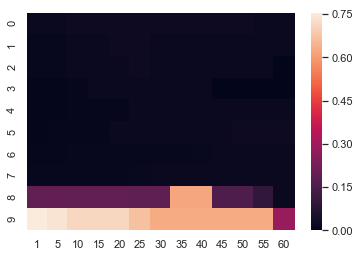

In [16]:
sns.heatmap(df)

Text(0.5,1,'MDF at timepoint 9 vs NADH conc in 0.01 mM')

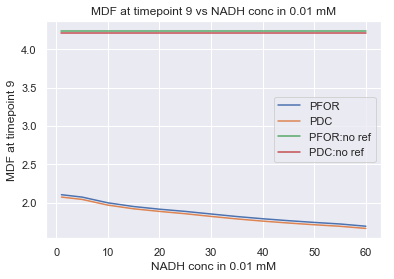

In [19]:
import seaborn as sns
sns.set()
mdf_data={}
for k in range(4):
    mdf_data[k]={}
    for r in [1,5,10,15,20,25,30,35,40,45,50,55,60]:
        mdf_data[k][r]={}
        for t in range(10):
            mdf_data[k][r][t] = all_data[k][r][t]["mdf"]

y={}
for k in range(4):
    y[k]={}
    for r in [1,5,10,15,20,25,30,35,40,45,50,55,60]:
        y[k][r] = float(mdf_data[k][r][9]) 
import pandas as pd
df = pd.DataFrame.from_dict(y)

plt.plot(df)
plt.legend(['PFOR','PDC','PFOR:no ref','PDC:no ref'])
plt.xlabel('NADH conc in 0.01 mM')
plt.ylabel('MDF at timepoint 9')
plt.title('MDF at timepoint 9 vs NADH conc in 0.01 mM')

Text(0.5,1,'MDF at timepoint 8 vs NADH conc in 0.01 mM')

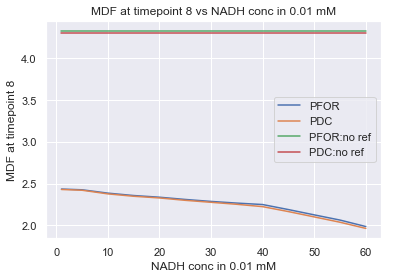

In [20]:
y={}
for k in range(4):
    y[k]={}
    for r in [1,5,10,15,20,25,30,35,40,45,50,55,60]:
        y[k][r] = float(mdf_data[k][r][8]) 
import pandas as pd
df = pd.DataFrame.from_dict(y)

plt.plot(df)
plt.legend(['PFOR','PDC','PFOR:no ref','PDC:no ref'])
plt.xlabel('NADH conc in 0.01 mM')
plt.ylabel('MDF at timepoint 8')
plt.title('MDF at timepoint 8 vs NADH conc in 0.01 mM')